In [1]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

이미지 크기: (450, 800, 3)


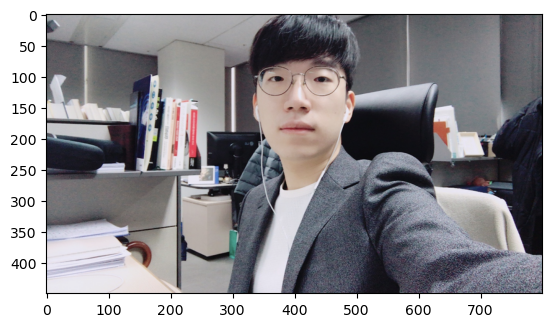

In [3]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

img_path = "images/my_image.png"
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
model = deeplabv3_resnet101(pretrained=True).eval()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [6]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [7]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 9.34 s, sys: 159 ms, total: 9.49 s
Wall time: 9.59 s


In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

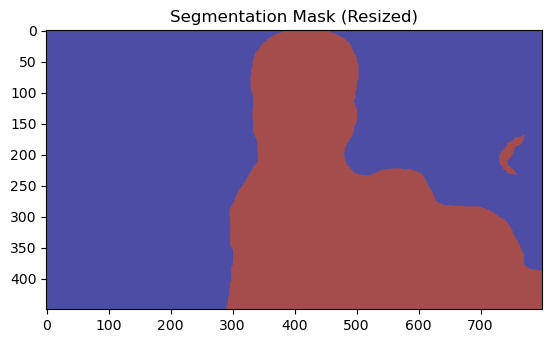

In [9]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [10]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [11]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

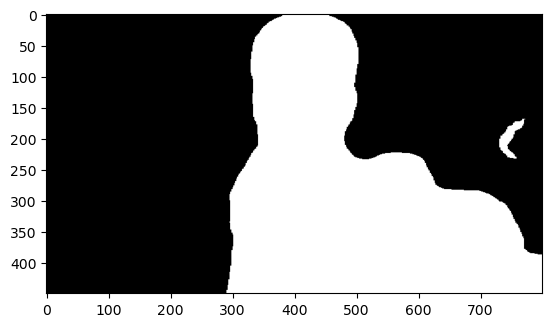

In [14]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

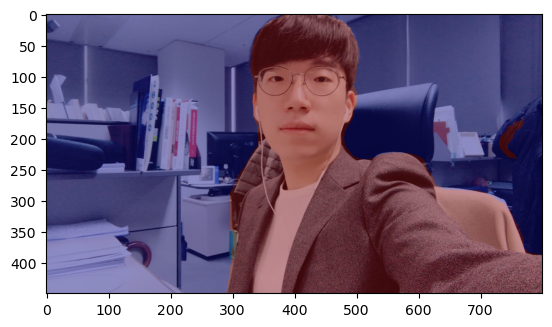

In [15]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

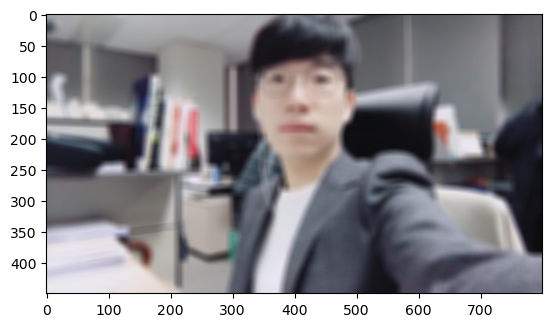

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

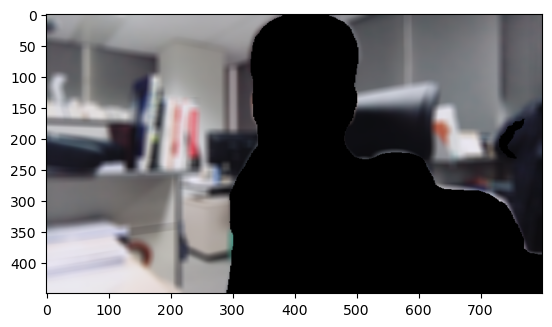

In [17]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

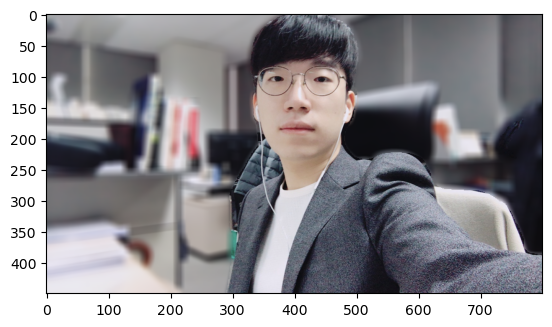

In [18]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

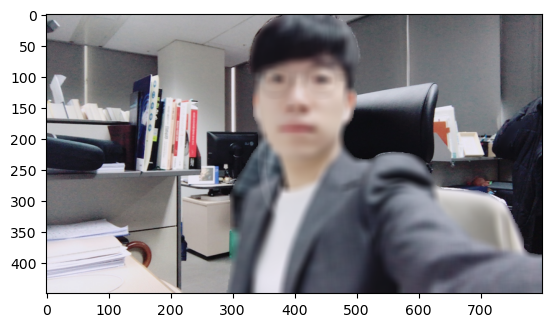

In [19]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# 추가한 부분
# 아웃포커싱 인물 모드 사진에서 문제점 개선

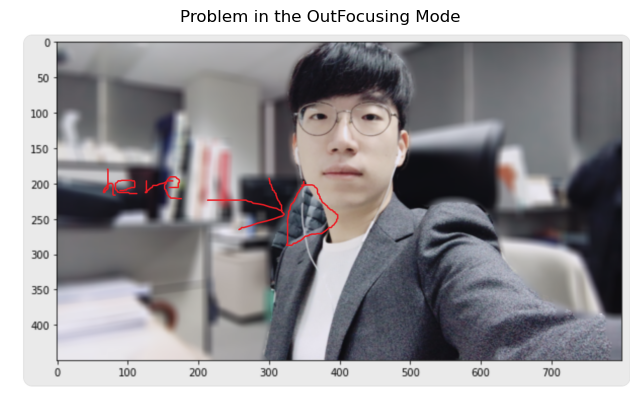

In [20]:
img = cv2.imread('images/here.png')

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.title("Problem in the OutFocusing Mode")
plt.axis('off')
plt.show()

In [21]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [22]:
# =============================
# 1. 모델 초기화 함수
# =============================
def load_models():
    # DeepLabV3 모델 (사람 영역 분리)
    seg_model = deeplabv3_resnet101(pretrained=True).eval()

    # MiDaS 모델 (깊이 추정)
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small", trust_repo=True).eval()

    # MiDaS 전처리기
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True).small_transform

    return seg_model, midas, midas_transforms

In [23]:
# =============================
# 2. 세그멘테이션 수행 함수 (일반화된 클래스 입력)
# =============================
def get_target_mask(img, model, target_classes=[15]):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])
    input_tensor = transform(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        prediction = output.argmax(0).byte().cpu().numpy()
        prediction_resized = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 여러 클래스에 대해 마스크 생성
    mask = np.isin(prediction_resized, target_classes).astype(np.uint8) * 255
    return mask

In [24]:
# =============================
# 3. 깊이 맵 추정 함수
# =============================
def estimate_depth(img, midas, midas_transforms):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_tensor = midas_transforms(img_rgb)

    with torch.no_grad():
        prediction = midas(input_tensor)
        depth = prediction.squeeze().cpu().numpy()
        depth = cv2.resize(depth, (img.shape[1], img.shape[0]))
        depth = cv2.normalize(depth, None, 0, 1, cv2.NORM_MINMAX)

    return depth

In [25]:
# =============================
# 4. 깊이 기반 마스크 필터링 함수
# =============================
def filter_mask_by_depth(mask, depth_map, tol=0.08):
    mask_bool = (mask > 127)
    target_depths = depth_map[mask_bool]

    if target_depths.size == 0:
        return mask  # 빈 마스크 예외 처리

    mean_depth = np.mean(target_depths)
    #lower, upper = mean_depth - tol, mean_depth + tol
    lower, upper = mean_depth - tol*0.2, mean_depth + tol # heuristic 하게 lower 과 upper 에서 tol 에 대한 가중치 설정
    valid_mask = (depth_map >= lower) & (depth_map <= upper)
    refined_mask = np.where(mask_bool & valid_mask, 255, 0).astype(np.uint8)

    return refined_mask

In [26]:
# =============================
# 5. 포커싱 이미지 생성 함수
# =============================
def apply_focus_effect(img, mask):
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    blurred = cv2.blur(img, (15, 15))
    bg_mask = cv2.bitwise_not(mask_color)
    bg_blur = cv2.bitwise_and(blurred, bg_mask)
    result = np.where(mask_color == 255, img, bg_blur)
    return result

In [27]:
# =============================
# 6. 결과 시각화 함수
# =============================
def visualize_results(original, mask, result_img):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Depth Refined Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Final Output")
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
# =============================
# 스크립트 실행
# =============================

# 이미지 경로
img_path = "images/my_image.png"
img = cv2.imread(img_path)

print(f"이미지 크기: {img.shape}")

# 모델 로드
seg_model, midas, midas_transforms = load_models()

# 세그멘테이션 및 마스크 생성
person_mask = get_target_mask(img, seg_model)

이미지 크기: (450, 800, 3)


Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master
/opt/conda/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /home/jovyan/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


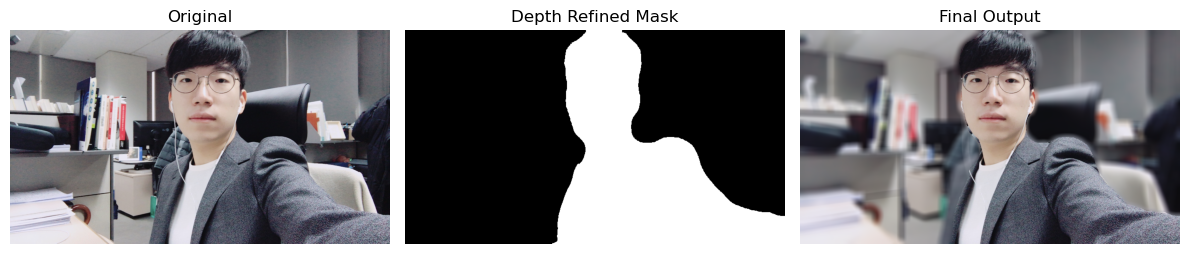

In [29]:
# 깊이 추정 및 마스크 보정
depth_map = estimate_depth(img, midas, midas_transforms)
refined_mask = filter_mask_by_depth(person_mask, depth_map, tol=0.5)

# 포커싱 이미지 생성
result_img = apply_focus_effect(img, refined_mask)

# 결과 시각화
visualize_results(img, refined_mask, result_img)

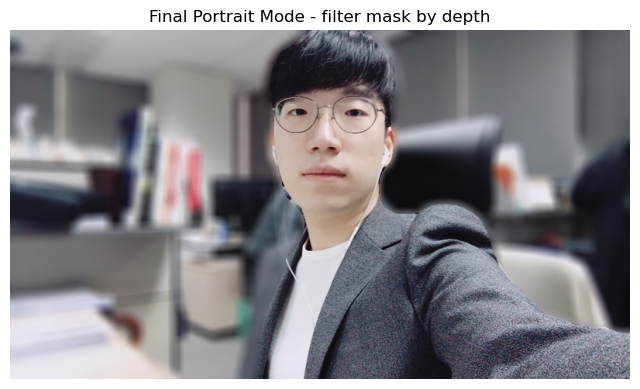

In [30]:
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.title("Final Portrait Mode - filter mask by depth")
plt.axis('off')
plt.show()

In [31]:
def main_without_depth_filtering(img_path, seg_model, num):
    img = cv2.imread(img_path)
    print(f"이미지 크기: {img.shape}")

    # 사람 마스크 추출
    person_mask = get_target_mask(img, seg_model, [num])

    # 깊이 보정 없이 바로 포커싱 적용
    result_img = apply_focus_effect(img, person_mask)

    # 시각화
    visualize_results(img, person_mask, result_img)

이미지 크기: (450, 800, 3)


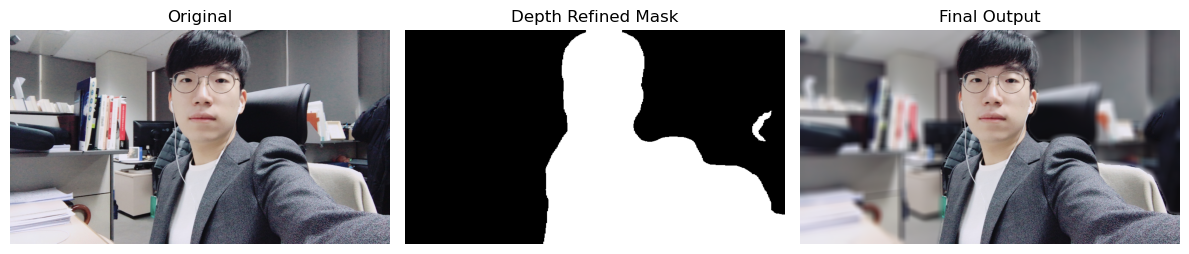

In [32]:
main_without_depth_filtering("images/my_image.png", seg_model, 15)

In [33]:
!pip install mplcursors

In [34]:
# 정밀한 depth 값을 구하기 위해 mplcursors 를 사용하여 마우스 커서에 값이 표시되도록 하는 작업

import matplotlib.pyplot as plt
import mplcursors

In [35]:
def show_depth_with_cursor(depth_map):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(depth_map, cmap='magma')
    plt.title("Hover to view depth (mean-colored)")
    plt.axis('off')

    # 마우스를 올리면 해당 픽셀의 값 출력
    cursor = mplcursors.cursor(im, hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(
        f"Depth: {depth_map[int(sel.target[1]), int(sel.target[0])]:.3f}"))

    plt.colorbar(im, shrink=0.7)
    plt.show()

In [36]:
# MiDaS 모델을 사용하여 이미지에서 카메라로 부터의 거리 정보 계산
def show_depth_heatmap(img, depth_map, alpha=0.6, cmap=cv2.COLORMAP_MAGMA):
    # Normalize depth map to [0, 255]
    depth_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_uint8 = depth_normalized.astype(np.uint8)

    # Apply colormap
    depth_colormap = cv2.applyColorMap(depth_uint8, cmap)

    # Resize colormap to original image shape if needed
    if depth_colormap.shape[:2] != img.shape[:2]:
        depth_colormap = cv2.resize(depth_colormap, (img.shape[1], img.shape[0]))

    # Overlay depth map on original image
    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1 - alpha, depth_colormap, alpha, 0)

    # Show
    plt.figure(figsize=(10, 5))
    plt.imshow(blended)
    plt.axis('off')
    plt.title("Depth Heatmap Overlay")
    plt.show()

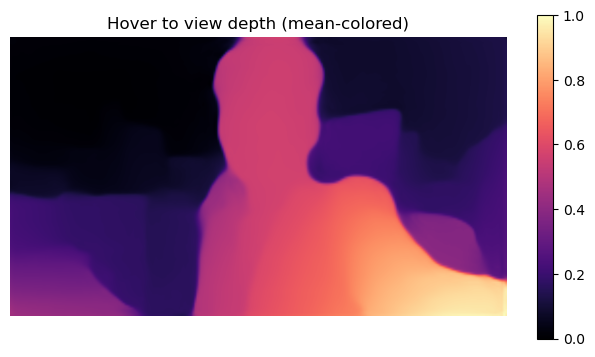

In [37]:
img = cv2.imread("images/my_image.png")

depth_map = estimate_depth(img, midas, midas_transforms)
show_depth_with_cursor(depth_map)

In [38]:
def show_depth_opencv(depth_map):
    # 정규화 및 컬러맵 적용
    depth_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_color = cv2.applyColorMap(depth_norm, cv2.COLORMAP_MAGMA)
    
    window_name = "Depth Viewer"

    def on_mouse(event, x, y, flags, param):
        if event == cv2.EVENT_MOUSEMOVE:
            d = depth_map[y, x]
            img_copy = depth_color.copy()
            cv2.putText(img_copy, f"Depth: {d:.3f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.imshow(window_name, img_copy)

    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, on_mouse)
    cv2.imshow(window_name, depth_color)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [39]:
# depth_map = estimate_depth(img, midas, midas_transforms)
# show_depth_opencv(depth_map)
# 실행 시 커널이 종료됨

In [ ]:
# 동물 사진 아웃포커싱

이미지 크기: (700, 700, 3)


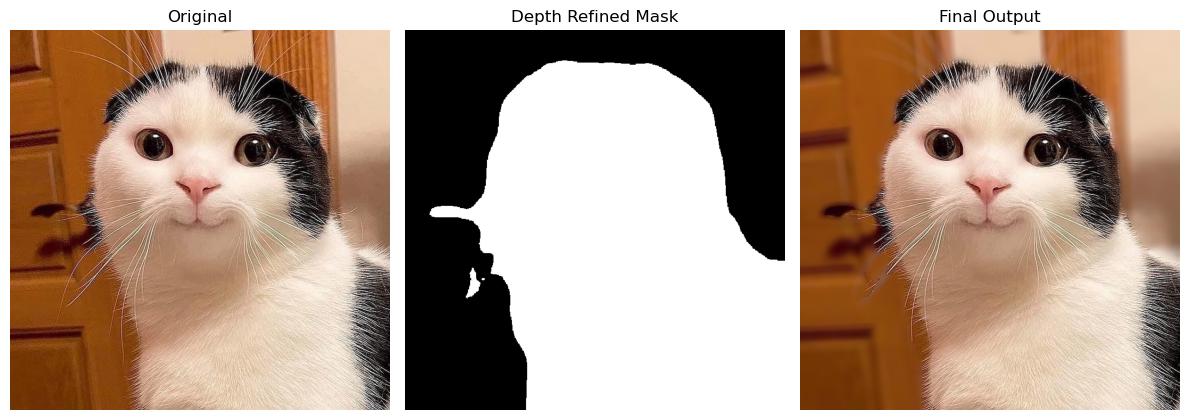

In [40]:
main_without_depth_filtering("images/kcat.jpg", seg_model, 8)

In [39]:
# =============================
# 스크립트 실행
# =============================
# 모델 로드
seg_model, midas, midas_transforms = load_models()

Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/jovyan/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


이미지 크기: (700, 700, 3)


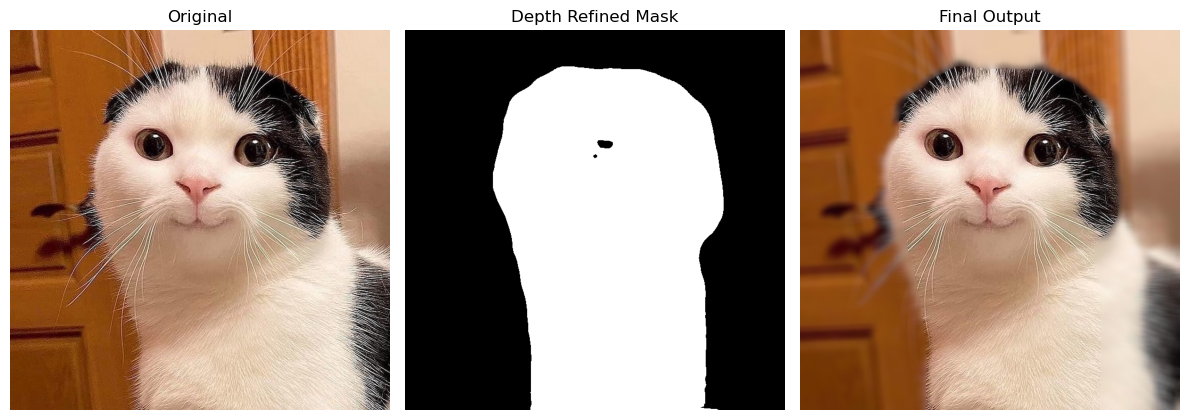

In [41]:
# 이미지 경로
img_path = "images/kcat.jpg"
img = cv2.imread(img_path)

print(f"이미지 크기: {img.shape}")

# 세그멘테이션 및 마스크 생성
person_mask = get_target_mask(img, seg_model, [8]) # cat : 8

# 깊이 추정 및 마스크 보정
depth_map = estimate_depth(img, midas, midas_transforms)
refined_mask = filter_mask_by_depth(person_mask, depth_map, tol=0.1)

# 포커싱 이미지 생성
result_img = apply_focus_effect(img, refined_mask)

# 결과 시각화
visualize_results(img, refined_mask, result_img)

In [41]:
# 배경 전환 크로마키

원본 고양이 이미지 크기: (236, 213, 3)
배경(사막) 이미지 크기: (250, 391, 3)


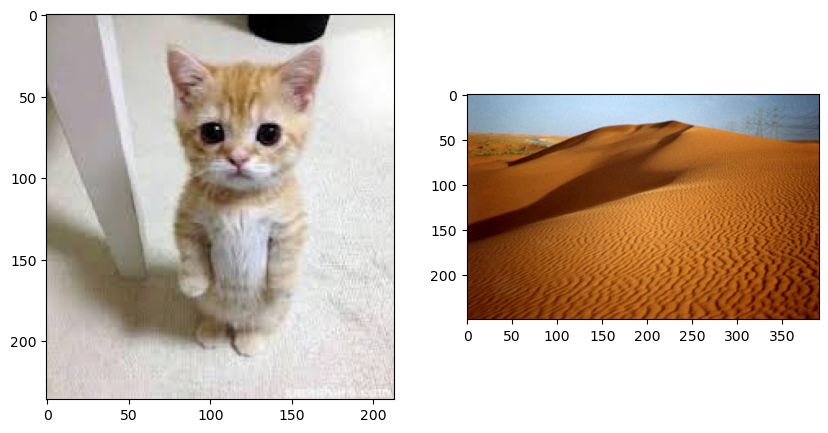

In [42]:
cat_img_path = "images/cat.jpeg"  # 고양이 이미지를 준비해주세요
sand_img_path = "images/sand.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [43]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [44]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (236, 213)


In [45]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


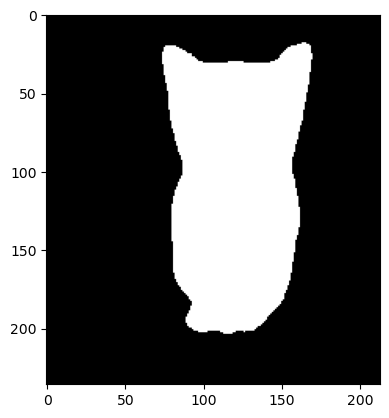

In [46]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

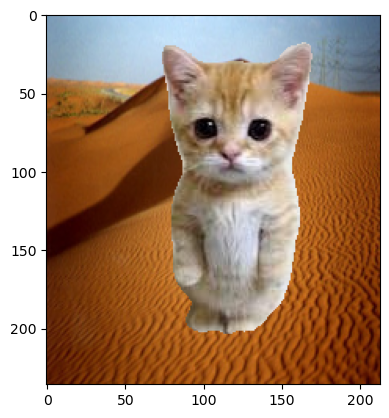

In [47]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

In [ ]:
# 회고
'''
인물 사진에서 뒷 배경의 옷 이미지까지 포함하여 포커싱이 되어서 이를 해결하기 위해 MiDaS 라는 단일 이미지 깊이 추정 모델을 사용함.
depth map 은 [0,1] 의 범위를 가지며, 카메라에서 가까울 수록 값이 작다.
이를 heatmap을 통해 애매한 경계가 어느 부분인지 알 수 있었고 해당 부분의 depth 값을 구하여 포커싱 범위를 설정할 수 있었다.
depth 에 대한 가중치인 tol 값을 조정하므로써 인물이 아닌 동물이나 새로운 포커싱 객체에 맞춰서 아웃포커싱을 적용할 수 있도록 
함수화 하였다.
배경 전환 크로마키에서 아쉬운 점은 배경과 객체의 경계선을 좀 더 부드럽게 하지 못했다는 점이다.
depth를 이용한 방법이 이외에도 포커싱한 부분 그 자체에서 경계면을 부드럽게 하는 방법인 CRF 또는 MiDaS 이후 Bilateral Filter 또는
Bokeh 스타일을 적용하면 더욱 자연스러운 포커싱과 배경 합성이 가능할 것이라고 생각한다.
세그멘테이션 모델 자체를 교환한다면 전처리 이전에 기본적인 성능을 향상시킬 수 있을 것이라고 기대한다.
이후에 자연어 모델을 사용하여 고양이, 사람에 대한 라벨 번호를 찾을 필요없이 문장으로 목적에 맞게 포커싱 및 합성을 하는 것도 시도해보고 싶다.
'''